In [1]:
from    tqdm.notebook       import  tqdm, trange

import  numpy               as      np

from    scipy.interpolate   import  RegularGridInterpolator
from    scipy.ndimage       import  map_coordinates

import  matplotlib.pyplot   as      plt
from    IPython             import  display

from    custom_kinetic.utils        import  *
from    custom_kinetic.distribution import  *

### Generate the grid

In [2]:
max_t:      float       = 10.0
delta_t:    float       = 0.05
num_t:      int         = int(1 + (max_t + 0.1*delta_t)/delta_t)
arr_t:      np.ndarray  = np.linspace(0, max_t, num_t)

dim:        int         = 2
max_x:      float       = 40.0
num_x:      int         = 1 + 50
delta_x:    float       = (2*max_x) / (num_x-1)
_grid_x_1d: np.ndarray  = np.linspace(-max_x, max_x, num_x)

max_v:      float       = 8.0
num_v:      int         = 1 + 20
delta_v:    float       = (2*max_v) / (num_v-1)
_grid_v_1d: np.ndarray  = np.linspace(-max_v, max_v, num_v)


grid_xv = np.stack(
    np.meshgrid(
        *(_grid_x_1d for _ in range(dim)),
        *(_grid_v_1d for _ in range(dim)),
        indexing='ij',
    ),
    axis=-1,
)
grid_x_only = space_grid(dim, num_x, max_x, where_closed='both')
grid_v_only = space_grid(dim, num_v, max_v, where_closed='both')
grid_x = grid_x_only.reshape(*repeat(num_x, dim), *ones(dim), dim)
grid_v = grid_v_only.reshape(*ones(dim), *repeat(num_v, dim), dim)

__extent = [-max_v, max_v, max_x, -max_x]


print(f"{grid_x_only.shape=}, {grid_v_only.shape=}")
print(f"{grid_x.shape=}, {grid_v.shape=}, {grid_xv.shape=}")

grid_x_only.shape=(51, 51, 2), grid_v_only.shape=(21, 21, 2)
grid_x.shape=(51, 51, 1, 1, 2), grid_v.shape=(1, 1, 21, 21, 2), grid_xv.shape=(51, 51, 21, 21, 4)


In [3]:
delta_x / delta_t, delta_v, max_v * delta_t

(32.0, 0.8, 0.4)

In [4]:
# Initialize physical quantities
mean_density        = 1 + np.exp(-0.5 * (grid_x_only[..., 0]**2))
mean_velocity       = np.zeros((*mean_density.shape, dim))
mean_temperature    = 1 + np.zeros_like(mean_density)

print(f"{mean_density.shape     =}")
print(f"{mean_velocity.shape    =}")
print(f"{mean_temperature.shape =}")

mean_density.shape     =(51, 51)
mean_velocity.shape    =(51, 51, 2)
mean_temperature.shape =(51, 51)


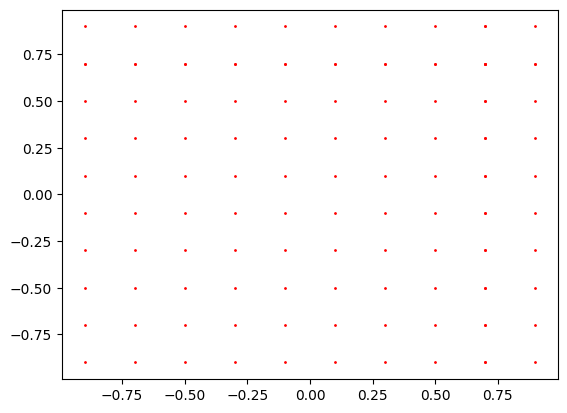

In [5]:
_u = np.linspace(-1, 1, 11)
u = np.stack(np.meshgrid(_u, _u, indexing='ij'), axis=-1)
u -= 0.3
u = (u+1) % 2 -1
plt.scatter(x=u[..., 0].flatten(), y=u[..., 1].flatten(), s=1, c='r')
plt.show()

## Multidimensional BGK equation

1. Trace backward with the approximation by interpolation.
2. Compute the collision term using the interpolation, and update the distribution function.

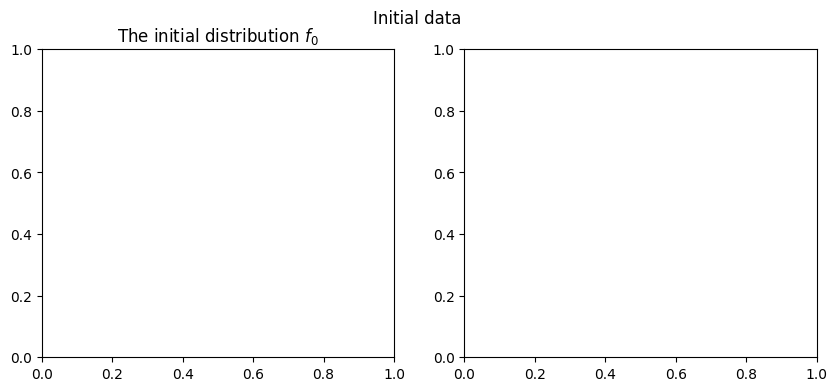

In [6]:
f_init = maxwellian_inhomogeneous(
                grid_xv,
                mean_density,
                mean_velocity,
                mean_temperature
            ) * np.sum(grid_v**2, axis=-1) / 150
arr_f: np.ndarray = f_init
equi_init = maxwellian_inhomogeneous(
                    grid_xv,
                    *compute_moments_inhomogeneous(f_init, grid_v_only, eps=0.0),
                    eps=0.0,
                )


##################################################
##################################################

try:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle(f"Initial data")
    # Initial distribution
    axes[0].set_title(f"The initial distribution $f_0$")
    axes[0].imshow(f_init, extent=__extent, aspect='auto')
    axes[0].set_xlabel("$v$")
    axes[0].set_ylabel("$x$")
    # Initial Maxwellian
    axes[1].set_title(f"The initial Maxwellian $M[f_0]$")
    axes[1].imshow(equi_init, extent=__extent, aspect='auto')
    axes[1].set_xlabel("$v$")
    axes[1].set_ylabel("$x$")

    plt.show()
except:
    True

In [7]:
# Define the collision operator
def collision(__PLACEHOLDER__t_curr: float, f_curr: np.ndarray) -> np.ndarray:
    moments = compute_moments_inhomogeneous(f_curr, grid_v_only)
    equi_curr = maxwellian_inhomogeneous(grid_xv, *moments)
    return (equi_curr - f_curr) / relaxation_time


# Configurations for the semi-Lagrangian scheme for the BGK equation
query: np.ndarray = grid_xv.copy()
# Modify the x-coordinates
query[..., :dim] -= delta_t * query[..., dim:]
query[..., :dim] = (query[..., :dim] + max_x) % (2*max_x) - max_x
relaxation_time:    float   = 0.5

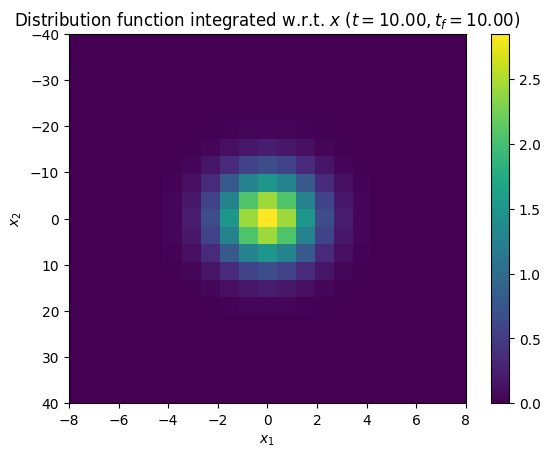

In [8]:
arr_distribution    = []
arr_mean_density    = []
arr_mean_velocity   = []
arr_total_energy    = []
arr_entropy         = []

t_curr: float = 0.0

fig, ax = plt.subplots(1, 1, figsize=(5,7))
for idx in range(num_t):
    arr_distribution.append(arr_f)
    
    if idx < num_t and dim in [1, 2]:
        if dim == 1:
            plt.imshow(arr_f, extent=__extent, aspect='auto')
            plt.title(f"Distribution function ($t={t_curr:.2f}, t_f={max_t:.2f}$)")
            plt.xlabel("$v$")
            plt.ylabel("$x$")
        elif dim == 2:
            plt.imshow(arr_f.sum(axis=(0,1)), extent=__extent, aspect='auto')
            plt.title(f"Distribution function integrated w.r.t. $x$ ($t={t_curr:.2f}, t_f={max_t:.2f}$)")
            plt.xlabel("$x_1$")
            plt.ylabel("$x_2$")
        plt.colorbar()
        plt.show()
        display.clear_output(wait=True)
        r, u, T = compute_moments_inhomogeneous(arr_f, grid_v_only, eps=0.0)
        arr_mean_density.append(
            np.mean(r)
        )
        arr_mean_velocity.append(
            np.mean(r[..., None] * u, axis=tuple(range(dim)))
        )
        arr_total_energy.append(
            compute_energy_inhomogeneous(arr_f, grid_v_only, delta_x**dim)
        )
        arr_entropy.append(
            compute_entropy_inhomogeneous(arr_f, grid_xv, dx=delta_x**dim)
        )
    else:
        break
    
    # Phase 1. Advection
    ## Generate the interpolator for each time step
    interp = RegularGridInterpolator(
        (
            *(_grid_x_1d for _ in range(dim)),
            *(_grid_v_1d for _ in range(dim)),
        ),
        arr_f,
        method = 'linear',
        # bounds_error = False, fill_value = 0.0,
    )
    arr_f: np.ndarray = interp(query)
    
    # Phase 2. Collision
    arr_f = one_step_RK4_classic(t_curr, arr_f, delta_t, collision)
    
    # Update the arguments
    t_curr += delta_t

arr_distribution        = np.array(arr_distribution)
arr_mean_density        = np.array(arr_mean_density)
arr_mean_velocity       = np.array(arr_mean_velocity)
arr_total_energy        = np.array(arr_total_energy)
arr_entropy             = np.array(arr_entropy)

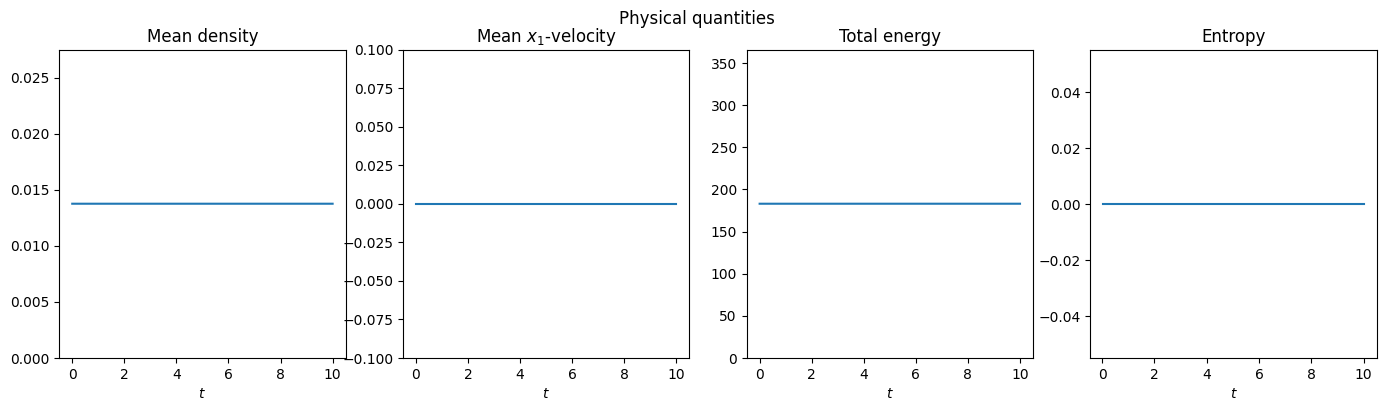

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))
# for idx, t_curr in enumerate(arr_t):
fig.suptitle(f"Physical quantities")
axes[0].plot(arr_t, arr_mean_density)
axes[1].plot(arr_t, arr_mean_velocity[..., 0])
axes[2].plot(arr_t, arr_total_energy)
axes[3].plot(arr_t, arr_entropy)
axes[0].set_title(f"Mean density")
axes[1].set_title(f"Mean $x_1$-velocity")
axes[2].set_title(f"Total energy")
axes[3].set_title(f"Entropy")
axes[0].set_ylim(0, 2*arr_mean_density.max())
axes[1].set_ylim(arr_mean_velocity[:, 0].mean() - 0.1, arr_mean_velocity[:, 0].mean() + 0.1)
axes[2].set_ylim(0, 2*arr_total_energy.max())
# axes[3].set_ylim(2*arr_entropy.min(), 0)
axes[0].set_xlabel("$t$")
axes[1].set_xlabel("$t$")
axes[2].set_xlabel("$t$")
axes[3].set_xlabel("$t$")
plt.show()

In [10]:
arr_entropy

array([nan, -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0

In [11]:
if False:
    np.savez(
        file = f"DVM_{dim}D__BGK_res{len(_grid_x_1d)}_L{max_v:.2e}_T{max_t}_dt{delta_t:.2e}",
        
        metric_order            = None,
        elapsed_time            = None,
        
        min_t                   = 0.0,
        max_t                   = max_t,
        delta_t                 = delta_t,
        
        arr_distribution        = arr_distribution,
        arr_mean_density        = arr_mean_density,
        arr_mean_velocity       = arr_mean_velocity,
        arr_mean_temperature    = arr_mean_temperature,
        arr_rel_error           = None,
    )

End of file